In [26]:
# Simulate species outlet concentrations in a plug flow reactor (PFR).

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.style.use("seaborn-pastel")

plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 120

# paper: https://www.sciencedirect.com/science/article/pii/S1540748920305757?via%3Dihub

T_range = [T for T in range (900,1325,10)]  # Inlet temperature, Kelvin

pressure = 0.04*1e5  # constant pressure, Pa

# input file containing the reaction mechanism
reaction_mechanism = 'files/output.yaml'

# Define the components and concentrations. The names must match to thoes in your model:
phi = 5.5/21
composition = {"furfuryl(1)": 1, "O2(2)": 5.5/phi, "N2": 5.5*3.76/phi}

length = 0.22  # *approximate* PFR length, m
internal_diameter = 0.007 #m
area = np.pi*(1/4)*internal_diameter**2  # cross-sectional area, m^2
inlet_flow_rate = 0.001/60  #in my case it's 1 L/minute = 0.001 m^3/60 sec
u_0 = inlet_flow_rate/area  # inflow velocity, m/s 

# Give a name for the output figure. Define as None to supress saving the figure:
figure_name = 'files/PFR_mol_frac'

# Whether to make the Y axis in log scale
semi_log_y = True

# Resolution: The PFR will be simulated by 'n_steps' time steps or by a chain of 'n_steps' stirred reactors.
n_steps = 2000

# approximate a time step to achieve a similar resolution as in the next method
t_total = length / u_0
dt = t_total / n_steps
# define time, space, and other information vectors
t1 = (np.arange(n_steps) + 1) * dt

# import the gas model and set the initial conditions
gas1 = ct.Solution(reaction_mechanism)
species = gas1.species_names

outlet_conc_dict={} # {Ti: {specie1: outlet_conc1, specie2: outlet_conc2},..}

for T in T_range:
    gas1.TPX = T, pressure, composition
    mass_flow_rate1 = u_0 * gas1.density * area
    # create a new reactor
    r1 = ct.IdealGasConstPressureReactor(gas1)
    # create a reactor network for performing time integration
    sim1 = ct.ReactorNet([r1])
    z1 = np.zeros_like(t1)
    u1 = np.zeros_like(t1)
    states1 = ct.SolutionArray(r1.thermo)
    for n1, t_i in enumerate(t1):
        # perform time integration
        sim1.advance(t_i)
        # compute velocity and transform into space
        u1[n1] = mass_flow_rate1 / area / r1.thermo.density
        z1[n1] = z1[n1 - 1] + u1[n1] * dt
        states1.append(r1.thermo.state)
    temp_dict= {} #{in each T, specie: [outlet conc] }
    for label in species:
        if 'Ar' not in label and 'N2' not in label:
            temp_dict[label] = states1.X[-1, gas1.species_index(label)] #outlet conc for each specie
    outlet_conc_dict [T] = temp_dict
#print(outlet_conc_dict)


/tmp/ipykernel_1052665/2650795431.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-pastel")


{900: {'Ne': 0.0, 'furfuryl(1)': 0.009902906549555737, 'O2(2)': 0.2080022690523773, 'H(3)': 1.5159218805531454e-10, 'OH(7)': 1.968708788276522e-11, 'H2O(9)': 2.0633304806193295e-07, 'HO2(10)': 5.695369831381764e-07, 'VA(30)': 5.427979787307087e-09, 'CH2CO(47)': 1.3796669964822099e-12, 'CO(49)': 1.1963440550949631e-06, 'CO2(50)': 1.6546631558894685e-12, 'CHCHO(87)': 6.857583489626687e-20, 'C5H6O2(1246)': 1.3291515867422808e-18, 'C5H6O2(1249)': 3.8027764714127326e-16, 'C5H5O(1263)': 5.310787096822057e-07, 'C5H5O2(1266)': 6.5174461221891e-13, 'C5H6O2(1274)': 4.91759682608608e-11, 'C5H6O2(1275)': 9.392837682870821e-14, 'C5H6O4(1280)': 7.481551324020695e-18, 'C5H6O4(1283)': 1.0904308258638876e-18, 'C5H6O2(1287)': 1.7485362926221096e-13, 'C#CCO(1295)': 1.3796670650579644e-12, 'C5H5O(1296)': 4.79444117945637e-12, 'C5H6O2(1302)': 2.8685185345624e-22, 'C5H6O2(1308)': 1.254973048718377e-13, 'C5H6O2(1346)': 6.901500711963228e-23, 'C5H6O2(1347)': 1.3200984080903085e-22, 'C5H6O4(1523)': 5.774623332

In [27]:
df_last_molfrac_exp = pd.read_csv('files/paper_2021_2FFOH_PFR.csv')
col_name_list_exp = list(df_last_molfrac_exp.columns) #the first column names are : 'Distance (m)', 'T (K)', 'P (Pa)'
T_exp_range = list(df_last_molfrac_exp['Temperature [K]'])
print(df_last_molfrac_exp)

    Temperature [K]  2-furfuryl alcohol      C2H2      C4H4       H2O  \
0               873            0.010000  0.000011  0.000022  0.000000   
1               898            0.010440  0.000012  0.000037  0.000032   
2               923            0.010537  0.000029  0.000057  0.000093   
3               948            0.010445  0.000031  0.000083  0.000050   
4               973            0.010715  0.000068  0.000142  0.000258   
5               998            0.010106  0.000126  0.000215  0.000215   
6              1023            0.009528  0.000207  0.000329  0.000292   
7              1048            0.008645  0.000406  0.000610  0.000426   
8              1073            0.007751  0.000639  0.001055  0.000514   
9              1098            0.005791  0.001134  0.001789  0.000851   
10             1123            0.003896  0.001742  0.002363  0.001194   
11             1148            0.002014  0.002115  0.002385  0.001142   
12             1173            0.000859  0.002431  

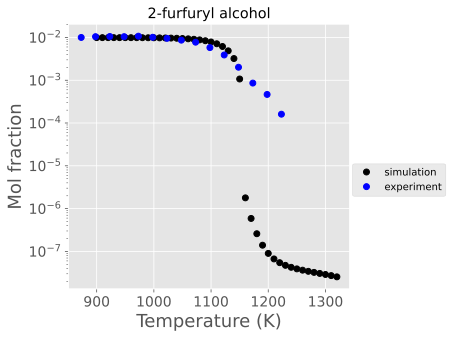

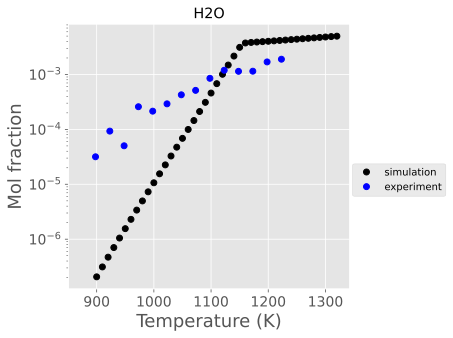

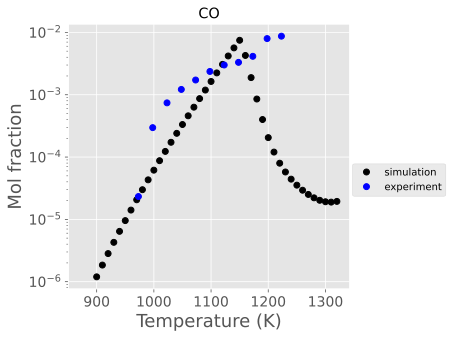

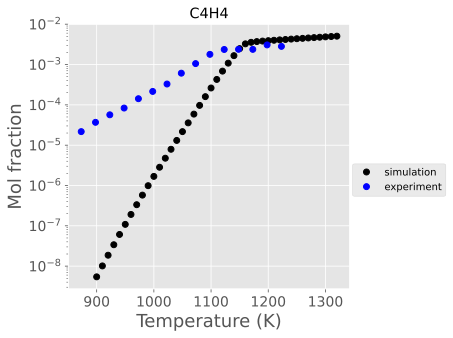

In [28]:
#simulating mol frac vs T:
#specie dict label: {exp specie label : sim specie label}
specie_label_dict = {
    "2-furfuryl alcohol" :"furfuryl(1)",
    "H2O" : "H2O(9)",
    "CO" : "CO(49)",
    "C4H4" : "VA(30)",#vinyl acetylene /but-1-en-3-yne
    #"C2H4" : "C2H4(30)",
	# "furan" : "C5H5O(48)",
	# "CH2O": "CH2O(98)",
	# "C2H2O":"C2H2O(81)",
	# "CH4":"CH4(73)",
	# "vinylketene":"C4H4O(45)",
}

for specie in specie_label_dict.keys():
    plt.figure()
    exp_mol_frac = list(df_last_molfrac_exp[specie])
    sim_mol_frac =[]
    for T in T_range:
        exp_specie_name=specie_label_dict[specie]
        sim_mol_frac.append(outlet_conc_dict[T][exp_specie_name])

    if semi_log_y:
        plt.semilogy(T_range, sim_mol_frac, "ko", label = "simulation")
        plt.semilogy(T_exp_range, exp_mol_frac,"bo",label = "experiment")
    else:
        plt.plot(T_range, sim_mol_frac, "ko", label = "simulation")
        plt.plot(T_exp_range, exp_mol_frac,"bo",label = "experiment")

    plt.xlabel("Temperature (K)")
    plt.ylabel('Mol fraction')
    plt.legend(loc=(1.01,.35)) #locate legend outside plot
    plt.title(specie)
    if figure_name:
        plt.savefig(figure_name+"_"+specie+".jpg", dpi=300, format='jpg')
    plt.show()